# Introductie

Computer vision is, naast natural language processing (NLP), een domein binnen machine learning waar alles draait rond **neurale netwerkmodellen**. Computer vision richt zich op het automatisch interpreteren en begrijpen van digitale beelden. Het domein stond in het middelpunt van verschillende grote AI doorbraken. Het onderging in de voorbije decennia een ware transformatie onder impuls van (diepe) **_Convolutional Neural Networks (CNN)_** en meest recent, **_Vision Transformers_**.  
  
In tegenstelling tot gestructureerde data waar we werken met tabulaire gegevens, hebben we hier te maken met beelden (RGB, RGB-D, hyper-spectraal, point-cloud) en sequenties daarvan. Het zijn bij uitstek voorbeelden van **ongestructureerde data**.  
  
Alles draait om de **automatische extractie van visuele features**. Daar waar dit lang gebeurde op basis van deterministische filters, brachten CNNs de mogelijkheid om die filters rechtstreeks uit de data te leren wat een enorme sprong in performantie en flexibiliteit met zich meebracht.  


:::{note} 🌍
:icon: false
:class: simple 
Een voorbeeld van **deterministische feature extractie** is het _Canny edge detection_ algoritme.

[![](https://img.shields.io/badge/Wikipedia-000?logo=wikipedia&logoColor=fff&style=flat)](https://en.wikipedia.org/wiki/Canny_edge_detector)

_Canny edge detection_ is een klassieke computer vision techniek die randen in beelden detecteert aan de hand van een reeks vaste bewerkingen:

1. _Noise reduction_: Gaussian blur filter om ruis te verminderen
2. _Gradient berekening_: Bepalen van intensiteitsgradiënten (Sobel filters)
3. _Non-maximum suppression_: Dunne randen behouden, dikke randen elimineren
4. _Double threshold_: Onderscheid tussen sterke en zwakke randen
5. _Edge tracking by hysteresis_: Zwakke randen behouden enkel als ze verbonden zijn met sterke randen

Dit is een volledig **deterministisch proces** - er worden géén parameters geleerd uit data. De filters en drempelwaarden zijn handmatig ontworpen door domeinexperts. Dit contrasteert sterk met moderne deep learning benaderingen waar CNNs automatisch optimale filters leren uit trainingsdata.
:::

In [1]:
import cv2
import numpy as np
from matplotlib import patches
from matplotlib import pyplot as plt

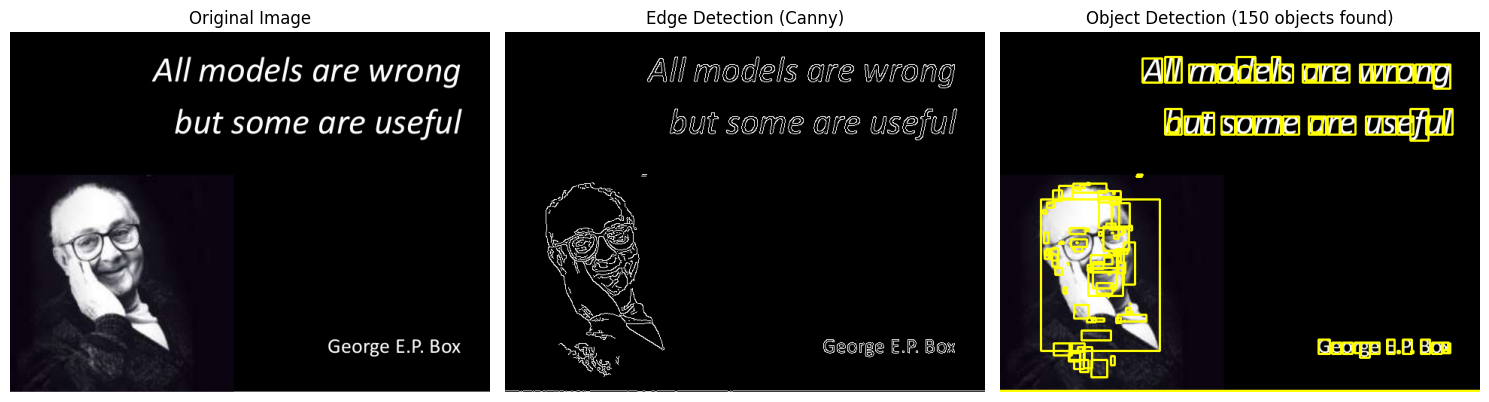

In [2]:
# Load an example image (you can replace this with your own image path)
# For demo purposes, we'll create a simple synthetic image
image = np.ones((400, 600, 3), dtype=np.uint8) * 255

# Add some simple shapes to detect
cv2.rectangle(image, (50, 50), (150, 150), (255, 0, 0), -1)
cv2.circle(image, (400, 200), 60, (0, 255, 0), -1)
cv2.rectangle(image, (450, 300), (550, 380), (0, 0, 255), -1)


image = cv2.imread("../../../img/all_models_are_wrong.jpg")

# Convert to grayscale for feature detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_single = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection (deterministic feature extraction)
edges = cv2.Canny(gray_single, 50, 150)

# Find contours (object detection based on edges)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around detected objects
result = image.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 2)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Edge Detection (Canny)")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"Object Detection ({len(contours)} objects found)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Neurale netwerkmodellen kunnen veel flexibeler ingezet worden doordat ze zelf op zoek gaan naar de meest gepaste feature extractie. De laatste jaren is die flexibiliteit nog veel groter geworden door de komst van zogenaamde **_foundation_ modellen**. Dit zijn doorgaans zeer grote (_large_) modellen die met enorme hoeveelheden beelden getraind zijn met ook verschillende taken (object detectie, segmentatie, captioning enz.). Ze hebben een enorme **generalisatie** capaciteit. Dit wil zeggen dat ze erg goede performantie behalen bij ongezien data. AI engineers kunnen daardoor meer en meer een beroep doen op **vooraf getrainde of _pretrained_** modellen die zonder of met minimale extra training ingezet kunnen worden.

:::{note} 🌍
:icon: false
:class: simple 
Het Florence model van Microsoft is een voorbeeld van een _foundation_ vision model.
:::

In [3]:
import random

from PIL import Image, ImageDraw
from transformers import AutoModelForCausalLM, AutoProcessor


In [4]:
model_id = "microsoft/Florence-2-base"
model = AutoModelForCausalLM.from_pretrained(
    model_id, attn_implementation="eager", trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


In [5]:
def run_example(task_prompt, text_input=None):
    """Run Florence model inference on an image with a given task prompt.

    Args:
        task_prompt: The task prompt for the model (e.g., '<CAPTION>', '<OBJECT_DETECTION>')
        text_input: Optional additional text input to append to the task prompt

    Returns
    -------
        Parsed answer from the model based on the task prompt
    """
    image = Image.open("../../../img/all_models_are_wrong.jpg").convert("RGB")
    prompt = task_prompt if text_input is None else task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    # Generate with use_cache=False to avoid past_key_values issues
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        do_sample=False,
        use_cache=False,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

    return parsed_answer

In [6]:
# Example usage for image captioning
caption = run_example("<CAPTION>")
print("Generated Caption:", caption)

Generated Caption: {'<CAPTION>': 'A black and white photo of a man with glasses.'}


In [7]:
def plot_bbox(data):
    """Plot bounding boxes on an image.

    Args:
        image: The image to display
        data: Dictionary containing 'bboxes' and 'labels' keys

    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    image = Image.open("../../../img/all_models_are_wrong.jpg").convert("RGB")
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data["bboxes"], data["labels"], strict=False):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color="white", fontsize=8, bbox={"facecolor": "red", "alpha": 0.5})

    # Remove the axis ticks and labels
    ax.axis("off")

    # Show the plot
    plt.show()


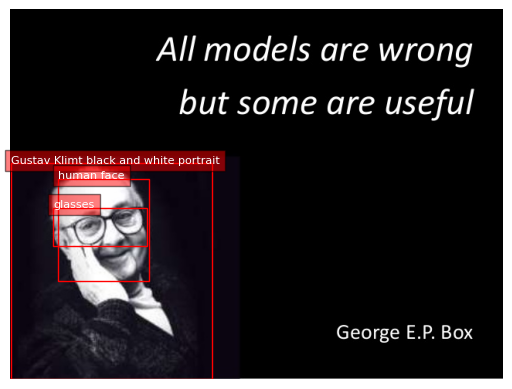

In [8]:
# Example usage for object detection
detection = run_example("<DENSE_REGION_CAPTION>")
plot_bbox(detection["<DENSE_REGION_CAPTION>"])

In [9]:
# Example usage for Optical Character Recognition (OCR)
ocr = run_example("<OCR>")
print("Detected text:", ocr)

Detected text: {'<OCR>': 'All models are wrongbut some are usefulGeorge E.P. Box'}


In [10]:
def draw_ocr_bboxes(prediction, scale=1):
    """Draw OCR bounding boxes on an image.

    Args:
        image: PIL Image object to draw on
        prediction: Dictionary containing 'quad_boxes' and 'labels' keys
        scale: Scale factor for bounding box coordinates (default: 1)

    """
    image = Image.open("../../../img/all_models_are_wrong.jpg").convert("RGB")
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction["quad_boxes"], prediction["labels"]
    colormap = [
        "red",
        "blue",
        "green",
        "purple",
        "orange",
        "yellow",
        "pink",
        "cyan",
        "magenta",
        "lime",
    ]
    for box, label in zip(bboxes, labels, strict=False):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0] + 8, new_box[1] + 2), f"{label}", align="right", fill=color)

    display(image)

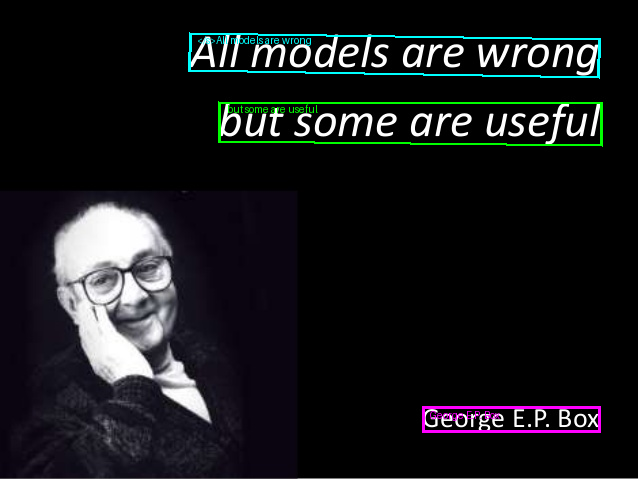

In [11]:
ocr_with_region = run_example("<OCR_WITH_REGION>")
draw_ocr_bboxes(ocr_with_region["<OCR_WITH_REGION>"])

De uitdagingen bij computer vision liggen heel anders dan bij gestructureerde data:

## Feature selectie
Bij camerasensoren zijn alle pixels van een beeld of beelden de input features voor een computer vision model. Er gebeurt geen manuele selectie van pixels, al kan er wel beslist worden om beelden aan te passen (vaak om meer variatie in de dataset te brengen):
- _Crop_: Er worden nieuwe beelden gemaakt via uitsnijding.
- Rotatie: Beelden worden onder verschillende hoeken gedraaid.
- Spiegelbeelden
- Schaling
- enz.  
  
Naargelang de specifieke camerasensoren, zijn er per pixel andere **kanalen** (_**channels**_) beschikbaar. Daar gebeuren soms wel selecties en/of transformaties. Bij standaard sensoren hebben we drie kanalen: rood, groen en blauw (RGB). Soms is er slechts één kanaal (bv. Röntgen scans of RGB beelden die omgezet worden in grijswaarden). Via fusion met andere sensoren is er soms een extra kanaal met diepte-informatie (RGB-D). Bij hyperspectrale camera's zijn er honderden kanalen (overeenkomstig met verschillende golflengtes in het lichtspectrum) en wordt vaak gefocust op bepaalde _banden_ (bv. infrarood).
  
[![](https://www.spectralpython.net/_images/hypercube.jpg)](https://www.spectralpython.net/)



Tenslotte wordt bij bepaalde toepassingen ook gewerkt met _point clouds_ - voornamelijk afkomstig van LiDAR sensoren. Hier zijn specifieke uitdagingen omdat het om _sparse_ 3D features gaat.  
  
[![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*N3wBVTOMubjAcgLKJUpGjQ.png)](https://medium.com/@BlanchR2/visualize-your-city-in-3d-a-quick-guide-to-lidar-point-clouds-in-python-00ae3cb2741b)

## Variabiliteit

Beelden zijn inherent complex en variabel - zeker wanneer ze _niet_ uit een gecontroleerde setting afkomstig zijn:
- **Schaalgrootte**: Zelfde objecten kunnen op heel verschillende afstanden van de camera staan en dus grote variaties in schaal vertonen
- **Rotatie en perspectief**: Objecten kunnen gedraaid zijn of vanuit verschillende hoeken bekeken worden
- **Belichting**: Lichtomstandigheden kunnen sterk variëren (dag/nacht, binnen/buiten, schaduwen)
- **Occlusie**: Objecten kunnen gedeeltelijk achter andere objecten verborgen zijn
- **Achtergrond**: Complexe achtergronden maken het onderscheiden van objecten moeilijk
- **Resolutie**: Zelfde objecten kunnen ook afhankelijk van de resolutie van de sensoren heel anders in beeld komen
- **Optische lens**: Een lens kan voor onscherpte zorgen, maar ook specifieke vervormingen (bv. _fish eye_ lenzen)
  
[![](https://www.researchgate.net/profile/Yohan-Dupuis/publication/301599480/figure/fig8/AS:667937144860676@1536260033134/Example-view-from-a-fisheye-camera-in-the-center-of-an-intersection-33.ppm)](https://www.researchgate.net/figure/Example-view-from-a-fisheye-camera-in-the-center-of-an-intersection-33_fig8_301599480)
  
Wanneer het belangrijk is voor de use-case om dezelfde objecten te kunnen herkennen op verschillende afstanden, bij verschillende belichting, enz. , moet er extra aandacht gaan naar het weerspiegelen van de juiste variabiliteit in de trainingsdata. Het is in die context niet verwonderlijk dat de meest performante modellen voor beeldanalyse _in the wild_ afkomstig zijn van internetgiganten met rechtstreekse toegang tot enorme hoeveelheden natuurlijk beeldmateriaal zoals Google en Meta. In gecontroleerde settings zoals productielijnen wordt samen met een camerasensor ook specifieke belichting voorzien om variabiliteit te verkleinen.
  
[![](https://advancedillumination.com/wp-content/uploads/2023/03/fig1-768x169.png)](https://advancedillumination.com/a-practical-guide-to-machine-vision-lighting/)
## _Ground truth_

_Supervised learning_ is de gouden standaard voor computer vision ML modellen. Het **verkrijgen van targets of zogenaamde _ground truth data_ (_class labels_, _bounding boxes_, segmentatie polygonen, _keypoints_, _captions_ enz.)** is echter niet vanzelfsprekend zoals bij het voorspellen van huisprijzen. Dit proces heet **beeldannotatie**. De grote doorbraken in vision AI zijn er gekomen dankzij enorme investeringen in annotatie door grote internetbedrijven. Er bestaan verschillende annotatieplatformen om dit proces minder arbeidsintensief en meer betrouwbaar te maken (bv. het oorspronkelijk Belgische [segments.ai](https://segments.ai/)).  
  
[![](https://thegradient.pub/content/images/2018/05/semseg.gif)](https://thegradient.pub/semantic-segmentation/)
  
Er zijn ook slimme applicaties om via _crowdsourcing_ geannoteerde beelden te bekomen.  
  
[![](https://miro.medium.com/v2/resize:fit:640/format:webp/0*cLG4GBuTx3lie90T.png?raw=true)](https://medium.com/nerd-for-tech/data-annotation-service-by-typing-captcha-you-are-actually-helping-ai-model-training-5902e8794a6f)
  
De recente evolutie richting _self-supervision_ en de groeiende **zero-/few-shot learning** capaciteit vermindert de nood aan zeer grote hoeveelheden geannoteerde beelden.  

[![](https://camo.githubusercontent.com/249381ff6bb722de458b088d88505da5c8ca3400f4148d9d9bbb91a9232d98c2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67?raw=true)](https://github.com/nightrome/cocostuff)

## (On)gebalanceerdheid en _bias_
Vooral bij beelden voor training die op natuurlijke wijze verkregen worden, schuilt het gevaar op over- en/of ondervertegenwoordiging waardoor _bias_ kan ontstaan - net zoals bij gestructureerde data. Omwille van de ongestructureerdheid van de data is het echter veel moeilijker om die ongebalanceerdheid op voorhand accuraat in kaart te brengen. Het komt _niet_ neer op simpele histogrammen van distributies te maken. Het gaat bijvoorbeeld over eenzijdige schaalgrootte, rotatie, belichting, enz. wat veel meer inspanning vraagt om vast te stellen. Er spelen zeker ook ethische aspecten mee, bijvoorbeeld bij herkenning/identificatie van personen met grote variaties in huidskleur.  

## Data volumes
Daar waar gestructureerde data vaak in grote getallen aanwezig zijn, is dit niet altijd het geval voor specifieke computer vision taken. Nochtans heeft een doorsnee deep learning model heel veel voorbeelden nodig - zeker wanneer het over natuurlijk beeldmateriaal gaat. Zoals reeds gezegd, hoeft het niet te verwonderen dat de beste modellen voor standaard camerasensoren afkomstig zijn van internetgiganten die beschikken over enorme hoeveelheden (geannoteerde) beelden. Doordat veel van die modellen _open source_ beschikbaar zijn in standaard bibliotheken zoals [PyTorch](https://docs.pytorch.org/vision/stable/index.html), [TensorFlow](https://www.tensorflow.org/tutorials/images) en [TensorRT](https://developer.nvidia.com/tensorrt), kunnen ze gebruikt worden als een _pretrained_ basis voor kleinschaligere toepassingen waarbij dan met veel kleinere datasets **_fine tuning_** of **_transfer learning_** gedaan kan worden. Hier komen we in de volgende secties op terug.  

## _Explainability_
Deep learning modellen zijn alomtegenwoordig voor computer vision taken. Dit type modellen zijn echter in grote mate _black boxes_. Het is heel moeilijk om model parameters te interpreteren en bijgevolg om te begrijpen hoe een specifieke modeloutput tot stand komt. Hierdoor ontstaat ook een ernstig risico op _model artefacten_. 
  
[![](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/5ec4/6219764/fee54eb3825c/pmed.1002683.g002.jpg?raw=true)](https://doi.org/10.1371/journal.pmed.1002683)  
  
[![](https://thegradient.pub/content/images/size/w800/2020/11/main-8.png)](https://thegradient.pub/interpretability-in-ml-a-broad-overview/)